In [3]:
import os
print(os.getcwd())
import joblib
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch
from torch.nn import Softmax
from torch.utils.data import DataLoader

from notebooks.utils.load_ckpt import define_model


from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
BATCH_SIZE=64
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

/home/hyeryungson/mucoco
cuda


In [4]:
# load jsonl
test=pd.read_json("./data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/fine-grained/test.jsonl",lines=True)
test2=pd.read_json("./data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/fine-grained/test_mucoco+add.jsonl",lines=True)

# noticed that there are samples with label value NaN
test = test.loc[~test['toxicity'].isna()]
test2 = test2.loc[~test2['toxicity'].isna()]

In [5]:
# load tokenizer
ckpt_path='./models_230507/roberta-base-jigsaw-toxicity-classifier-with-gpt2-large-embeds/checkpoint_best/pytorch_model.bin'
_, _, tokenizer = define_model(ckpt_path)

# create dataset, dataloader
test_enc = tokenizer(test['text'].tolist(), padding=True, truncation=True)
test_data = Dataset(test_enc, [0]*len(test['text']))
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

test2_enc = tokenizer(test2['text'].tolist(), padding=True, truncation=True)
test2_data = Dataset(test2_enc, [0]*len(test2['text']))
test2_dataloader = DataLoader(test2_data, batch_size=BATCH_SIZE, shuffle=False)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializin

DEVICE:  cuda


In [6]:
def get_model_prediction(input_ckpt_path, input_data_loader):
    _model, _, _ = define_model(input_ckpt_path)
    _logits=[]
    _proba=[]
    softmax=Softmax(dim=-1)
    with torch.no_grad():
        for batch in tqdm(input_data_loader):
            _input_ids = batch['input_ids'].to(DEVICE)
            _attention_mask = batch['attention_mask'].to(DEVICE)
            _labels = batch['labels'].to(DEVICE)
            _outputs = _model(_input_ids, attention_mask=_attention_mask, labels=_labels)
            _logits.append(_outputs)
            _proba.extend(softmax(_outputs['logits'])[:,1].cpu().numpy())
    return _proba

In [21]:
ckpt_path='./models_bak_contd/roberta-base-jigsaw-toxicity-classifier-with-gpt2-large-embeds/checkpoint_best/pytorch_model.bin'
test['pred_binary'] = get_model_prediction(ckpt_path, test_dataloader)
test2['pred_binary'] = get_model_prediction(ckpt_path, test2_dataloader)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializin

DEVICE:  cuda


100%|██████████| 62/62 [00:13<00:00,  4.64it/s]
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that

DEVICE:  cuda


100%|██████████| 71/71 [00:15<00:00,  4.61it/s]


In [22]:
ckpt_path='./models_230507/roberta-base-jigsaw-toxicity-classifier-with-gpt2-large-embeds/checkpoint_best/pytorch_model.bin'
test['pred_balanced'] = get_model_prediction(ckpt_path, test_dataloader)
test2['pred_balanced'] = get_model_prediction(ckpt_path, test2_dataloader)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializin

DEVICE:  cuda


100%|██████████| 62/62 [00:13<00:00,  4.60it/s]
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that

DEVICE:  cuda


100%|██████████| 71/71 [00:15<00:00,  4.58it/s]


In [5]:
ckpt_path='./models_230507/roberta-base-jigsaw-toxicity-classifier-with-gpt2-large-embeds/checkpoint_best/pytorch_model.bin'
test['pred_balanced'] = get_model_prediction(ckpt_path, test_dataloader)
test2['pred_balanced'] = get_model_prediction(ckpt_path, test2_dataloader)

ckpt_path='./models/roberta-base-jigsaw-toxicity-classifier-with-gpt2-large-embeds/checkpoint_best/pytorch_model.bin'
test['pred_add'] = get_model_prediction(ckpt_path, test_dataloader)
test2['pred_add'] = get_model_prediction(ckpt_path, test2_dataloader)

ckpt_path='./models_addmore/roberta-base-jigsaw-toxicity-classifier-with-gpt2-large-embeds/checkpoint_best/pytorch_model.bin'
test['pred_addmore'] = get_model_prediction(ckpt_path, test_dataloader)
test2['pred_addmore'] = get_model_prediction(ckpt_path, test2_dataloader)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializin

DEVICE:  cuda


100%|██████████| 63/63 [00:14<00:00,  4.29it/s]
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that

DEVICE:  cuda


100%|██████████| 71/71 [00:15<00:00,  4.55it/s]
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that

DEVICE:  cuda


100%|██████████| 63/63 [00:13<00:00,  4.53it/s]
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that

DEVICE:  cuda


100%|██████████| 71/71 [00:15<00:00,  4.53it/s]
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that

DEVICE:  cuda


100%|██████████| 63/63 [00:14<00:00,  4.49it/s]
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that

DEVICE:  cuda


100%|██████████| 71/71 [00:15<00:00,  4.46it/s]


In [11]:
test.to_csv('notebooks/results/test_preds.csv',index=False)
test2.to_csv('notebooks/results/test_mucoco+add_preds.csv',index=False)

In [7]:
ckpt_path='./models/roberta-base-jigsaw-toxicity-classifier-with-gpt2-large-embeds/data-balanced-loss-weighted/checkpoint_best/pytorch_model.bin'
test['pred_balanced_w'] = get_model_prediction(ckpt_path, test_dataloader)
test2['pred_balanced_w'] = get_model_prediction(ckpt_path, test2_dataloader)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializin

DEVICE:  cuda


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that

DEVICE:  cuda


100%|██████████| 71/71 [00:15<00:00,  4.61it/s]


In [5]:
# # load trained model
# ckpt_path='./models_230507/roberta-base-jigsaw-toxicity-classifier-with-gpt2-large-embeds/checkpoint_best/pytorch_model.bin'
# model, config, tokenizer = define_model(ckpt_path)

# logits=[]
# proba=[]
# softmax=Softmax(dim=-1)
# with torch.no_grad():
#     for batch in tqdm(label_dataloader):
#         input_ids = batch['input_ids'].to(DEVICE)
#         attention_mask = batch['attention_mask'].to(DEVICE)
#         labels = batch['labels'].to(DEVICE)
#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         logits.append(outputs)
#         proba.extend(softmax(outputs['logits'])[:,1].cpu().numpy())

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializin

DEVICE:  cuda


### Plot & Analyze Model Outputs

In [8]:
def evaluate_model(input_pred_data, input_column_name):
    _rvalue, _ = pearsonr(input_pred_data['toxicity'], input_pred_data[input_column_name])
    # print("Pearson R: %.3f" % rvalue)

    _RMSE = mean_squared_error(input_pred_data['toxicity'], input_pred_data[input_column_name])**0.5
    # print("RMSE: %.3f" % RMSE)

    _MAE = mean_absolute_error(input_pred_data['toxicity'], input_pred_data[input_column_name])
    # print("MAE: %.3f" % MAE)
    
    return _rvalue, _RMSE, _MAE

In [38]:
res = dict(test={}, test2={})
for model_name in ['balanced', 'add', 'addmore', 'binary']:
    for dataset_name in ['test', 'test2']:
        # print('test data: test, model: ', model_name)
        rvalue, RMSE, MAE = evaluate_model(eval(dataset_name), f'pred_{model_name}')
        res[dataset_name][model_name]=dict(rvalue=rvalue, RMSE=RMSE, MAE=MAE)

In [29]:
pd.DataFrame(res['test'])

,balanced,add,addmore,binary
rvalue,0.876933,0.911747,0.883292,0.874299
RMSE,0.177979,0.140318,0.163663,0.316003
MAE,0.131621,0.085562,0.123137,0.203539


In [10]:
evaluate_model(test, 'pred_balanced_w')

(0.8700756311545568, 0.19347409001381988, 0.14483973526729718)

In [30]:
pd.DataFrame(res['test2'])

,balanced,add,addmore,binary
rvalue,0.858189,0.893694,0.875295,0.831887
RMSE,0.180825,0.145319,0.158245,0.341997
MAE,0.134229,0.093419,0.118595,0.228976


In [11]:
evaluate_model(test2, 'pred_balanced_w')

(0.8493844738211176, 0.1980495601446774, 0.14820420580472934)

In [154]:
test2['toxicity_cat']=pd.cut(test2['toxicity'], np.arange(0, 1.11, 0.1), include_lowest=False, right=False)
rmse_by_bin=[]
mae_by_bin=[]
# print(pearsonr(test2['toxicity'], test2['pred_balanced'])[0])
for i, model_name in enumerate(['balanced', 'add', 'addmore', 'binary']):
    rmse = test2.groupby('toxicity_cat').apply(lambda x: round(mean_squared_error(x['toxicity'], x[f'pred_{model_name}'])**(1/2), 2))
    rmse.name = f'rmse_{model_name}'
    mae = test2.groupby('toxicity_cat').apply(lambda x: round(mean_absolute_error(x['toxicity'], x[f'pred_{model_name}']),2))
    mae.name = f'mae_{model_name}'
    rmse_by_bin.append(rmse)
    mae_by_bin.append(mae)

In [155]:
pd.concat(rmse_by_bin, axis=1)

,rmse_balanced,rmse_add,rmse_addmore,rmse_binary
toxicity_cat,,,,
"[0.0, 0.1)",0.18,0.11,0.13,0.25
"[0.1, 0.2)",0.20,0.18,0.11,0.44
"[0.2, 0.3)",0.20,0.18,0.11,0.47
"[0.3, 0.4)",0.20,0.18,0.11,0.58
"[0.4, 0.5)",0.20,0.19,0.14,0.53
"[0.5, 0.6)",0.20,0.17,0.16,0.48
"[0.6, 0.7)",0.16,0.13,0.16,0.39
"[0.7, 0.8)",0.14,0.12,0.16,0.28
"[0.8, 0.9)",0.15,0.18,0.23,0.18


In [156]:
pd.concat(mae_by_bin, axis=1)

,mae_balanced,mae_add,mae_addmore,mae_binary
toxicity_cat,,,,
"[0.0, 0.1)",0.12,0.05,0.10,0.06
"[0.1, 0.2)",0.15,0.14,0.08,0.33
"[0.2, 0.3)",0.15,0.15,0.08,0.38
"[0.3, 0.4)",0.16,0.17,0.09,0.55
"[0.4, 0.5)",0.18,0.16,0.12,0.53
"[0.5, 0.6)",0.17,0.13,0.13,0.48
"[0.6, 0.7)",0.14,0.09,0.12,0.38
"[0.7, 0.8)",0.10,0.09,0.12,0.28
"[0.8, 0.9)",0.09,0.13,0.16,0.17


In [23]:
test2['toxicity_cat']=pd.cut(test2['toxicity'], np.arange(0, 1.11, 0.1), include_lowest=False, right=False)
rmse_by_bin=[]
mae_by_bin=[]
min_by_bin=[]
# print(pearsonr(test2['toxicity'], test2['pred_balanced'])[0])
for i, model_name in enumerate(['balanced', 'balanced_w']):
    rmse = test2.groupby('toxicity_cat').apply(lambda x: round(mean_squared_error(x['toxicity'], x[f'pred_{model_name}'])**(1/2), 2))
    rmse.name = f'rmse_{model_name}'
    mae = test2.groupby('toxicity_cat').apply(lambda x: round(mean_absolute_error(x['toxicity'], x[f'pred_{model_name}']),2))
    mae.name = f'mae_{model_name}'
    rmse_by_bin.append(rmse)
    mae_by_bin.append(mae)

In [26]:
test2_grp= test2.groupby('toxicity_cat')
test2_grp['pred_balanced_w'].describe()

,count,mean,std,min,25%,50%,75%,max
toxicity_cat,,,,,,,,
"[0.0, 0.1)",1998.0,0.141228,0.143135,0.017040,0.042518,0.086422,0.185099,0.865842
"[0.1, 0.2)",201.0,0.256271,0.206840,0.021824,0.091034,0.208516,0.349774,0.883647
"[0.2, 0.3)",162.0,0.309390,0.198829,0.033992,0.153818,0.287235,0.447271,0.839007
"[0.3, 0.4)",97.0,0.406445,0.209669,0.056999,0.235887,0.371341,0.537292,0.859671
"[0.4, 0.5)",85.0,0.494412,0.219736,0.095996,0.294102,0.462519,0.692249,0.905957
"[0.5, 0.6)",661.0,0.609186,0.205521,0.043295,0.451217,0.650147,0.788975,0.918166
"[0.6, 0.7)",498.0,0.694464,0.166553,0.073716,0.599217,0.746997,0.825273,0.925746
"[0.7, 0.8)",397.0,0.752407,0.141601,0.187057,0.703813,0.808663,0.842301,0.918021
"[0.8, 0.9)",300.0,0.786197,0.135015,0.191272,0.773249,0.835051,0.864754,0.947433


In [24]:
pd.concat(rmse_by_bin, axis=1)

,rmse_balanced,rmse_balanced_w
toxicity_cat,,
"[0.0, 0.1)",0.18,0.20
"[0.1, 0.2)",0.20,0.23
"[0.2, 0.3)",0.20,0.22
"[0.3, 0.4)",0.20,0.23
"[0.4, 0.5)",0.20,0.23
"[0.5, 0.6)",0.20,0.22
"[0.6, 0.7)",0.16,0.18
"[0.7, 0.8)",0.14,0.14
"[0.8, 0.9)",0.15,0.14


In [12]:

def plot_heatmap(input_pred_data, input_pred_data_name, input_column_name, input_plot_axis, input_cbar, input_cbar_axis=None):
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    copy_pred_data = input_pred_data[['toxicity', input_column_name]].copy()
    # bin toxicity columns values
    copy_pred_data['toxicity_cat']=pd.cut(copy_pred_data['toxicity'], np.arange(0, 1.11, 0.1), include_lowest=False, right=False)
    copy_pred_data['mod_proba_cat']=pd.cut(copy_pred_data[input_column_name], np.arange(0, 1.11, 0.1), include_lowest=False, right=False)
    
    heatmap_data = copy_pred_data.groupby(['toxicity_cat', 'mod_proba_cat']).size().unstack(0).apply(lambda x: x/(x.sum()+0.1), axis=0)
    # print(heatmap_data)
    sns.heatmap(heatmap_data, ax=input_plot_axis, cbar=input_cbar, cbar_ax=input_cbar_axis, cbar_kws={ "orientation": "horizontal" })
    input_plot_axis.set_title(f'Test data: {input_pred_data_name}, Model: {input_column_name}')
    
def plot_boxplot(input_pred_data, input_pred_data_name, input_column_name, input_plot_axis):
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    copy_pred_data = input_pred_data[['toxicity', input_column_name]].copy()
    # bin toxicity columns values
    copy_pred_data['toxicity_cat']=pd.cut(copy_pred_data['toxicity'], np.arange(0, 1.11, 0.1), include_lowest=False, right=False)
    copy_pred_data['mod_proba_cat']=pd.cut(copy_pred_data[input_column_name], np.arange(0, 1.11, 0.1), include_lowest=False, right=False)
    
    sns.boxplot(data = copy_pred_data, x = 'toxicity_cat', y=input_column_name, ax=input_plot_axis)
    input_plot_axis.set_title(f'Test data: {input_pred_data_name}, Model: {input_column_name}')
    # input_plot_axis.set_xticklabels(rotation=45)
    input_plot_axis.set_ylim(top=1)
    input_plot_axis.set_ylabel('')

In [17]:
test2_others=pd.read_csv('./notebooks/results/test_mucoco+add_preds.csv')

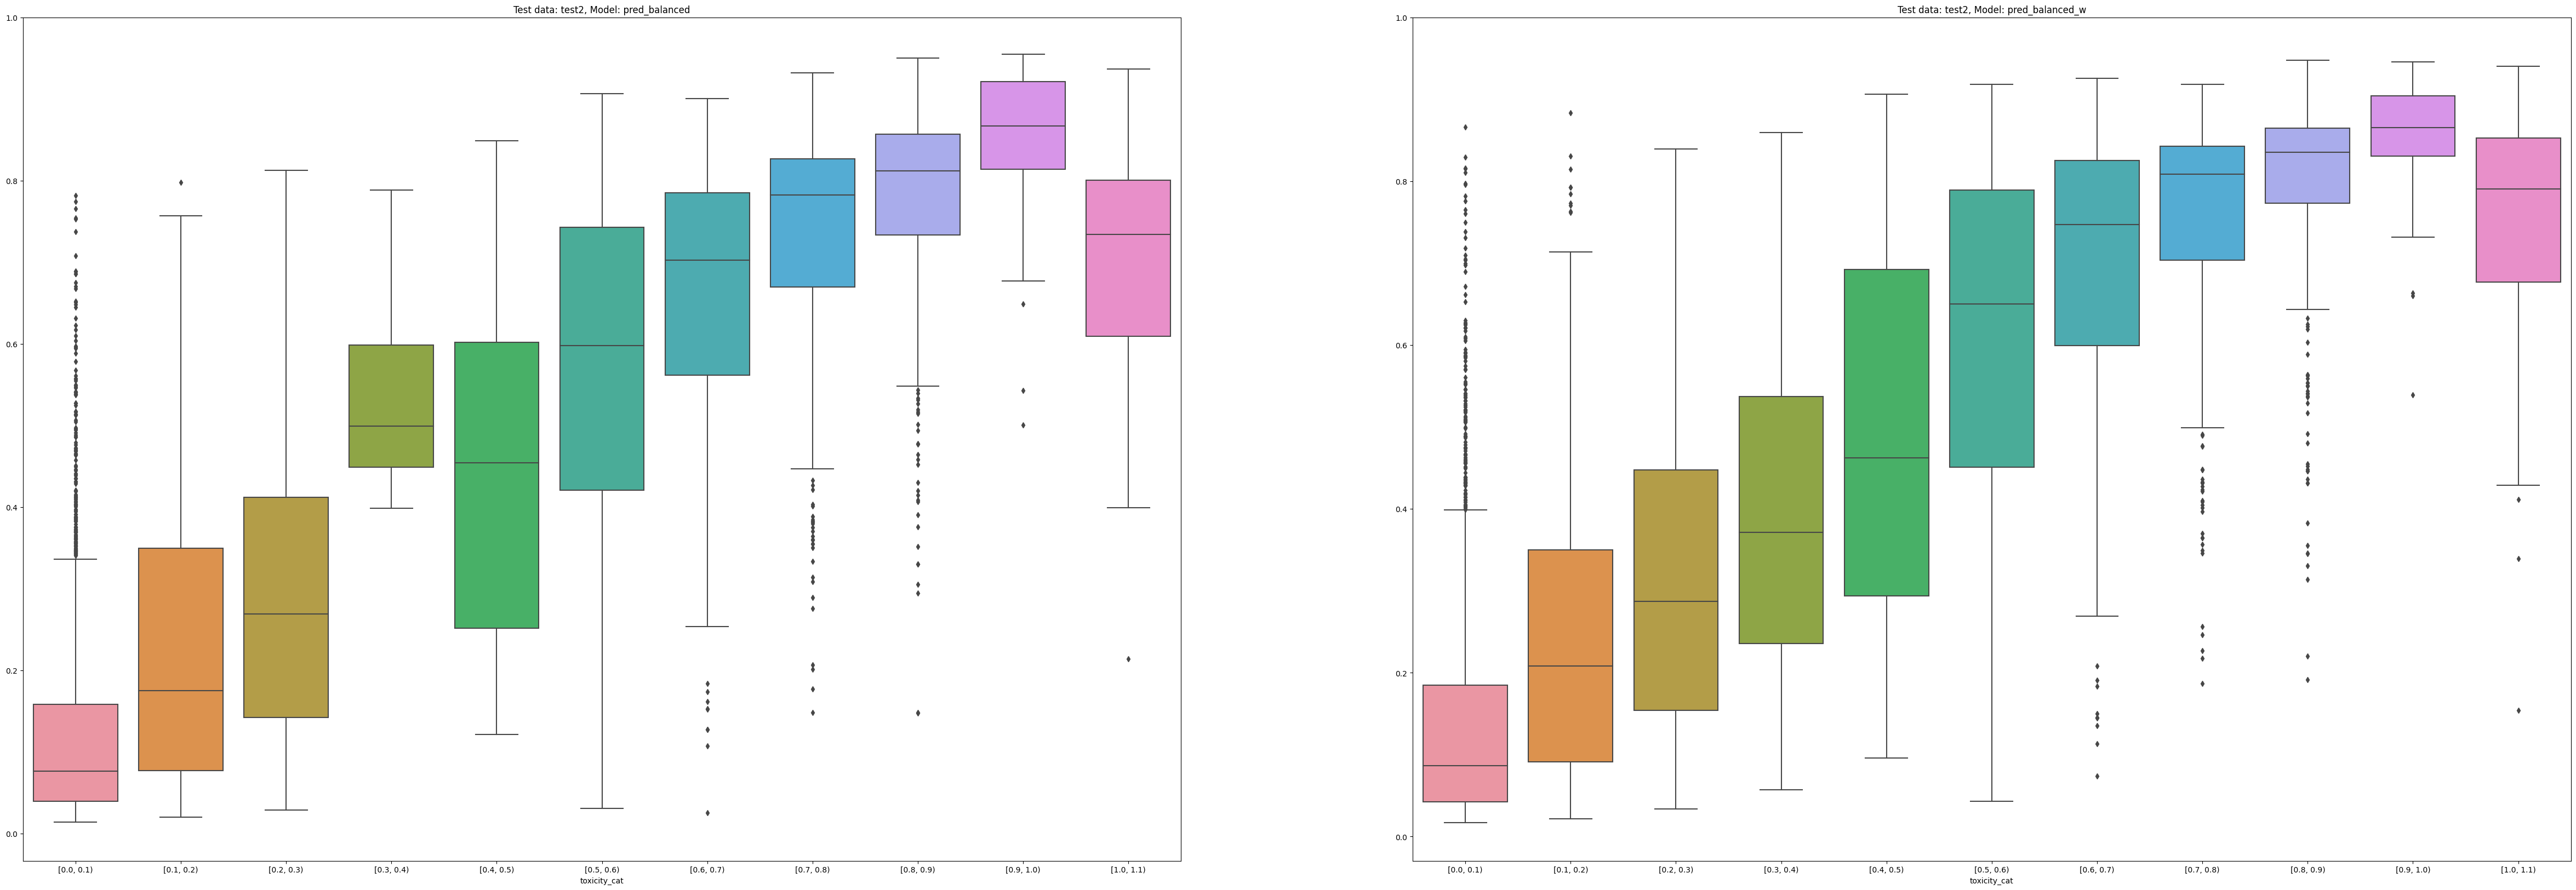

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(60, 20))
plot_boxplot(test2, 'test2', 'pred_balanced_w', axes[1])
plot_boxplot(test2_others, 'test2', 'pred_balanced', axes[0])

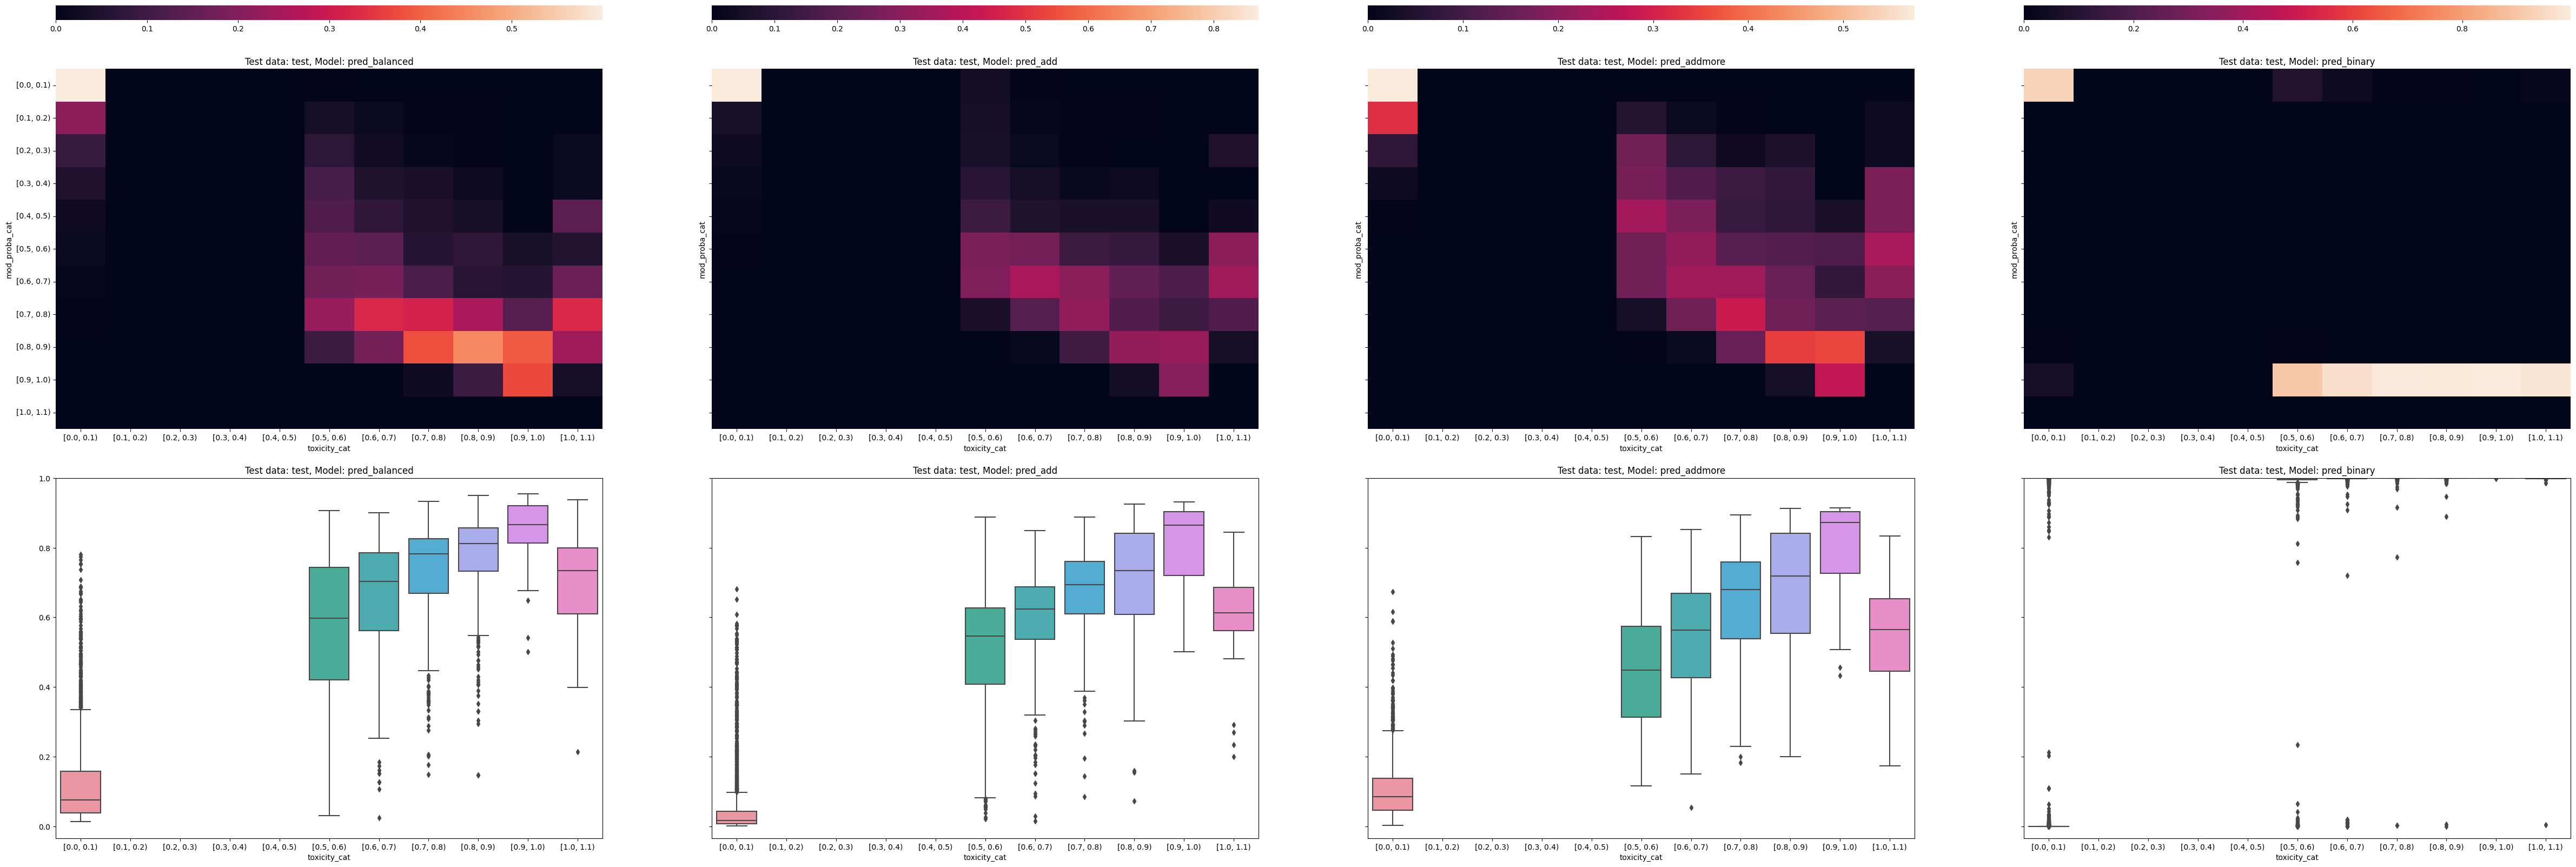

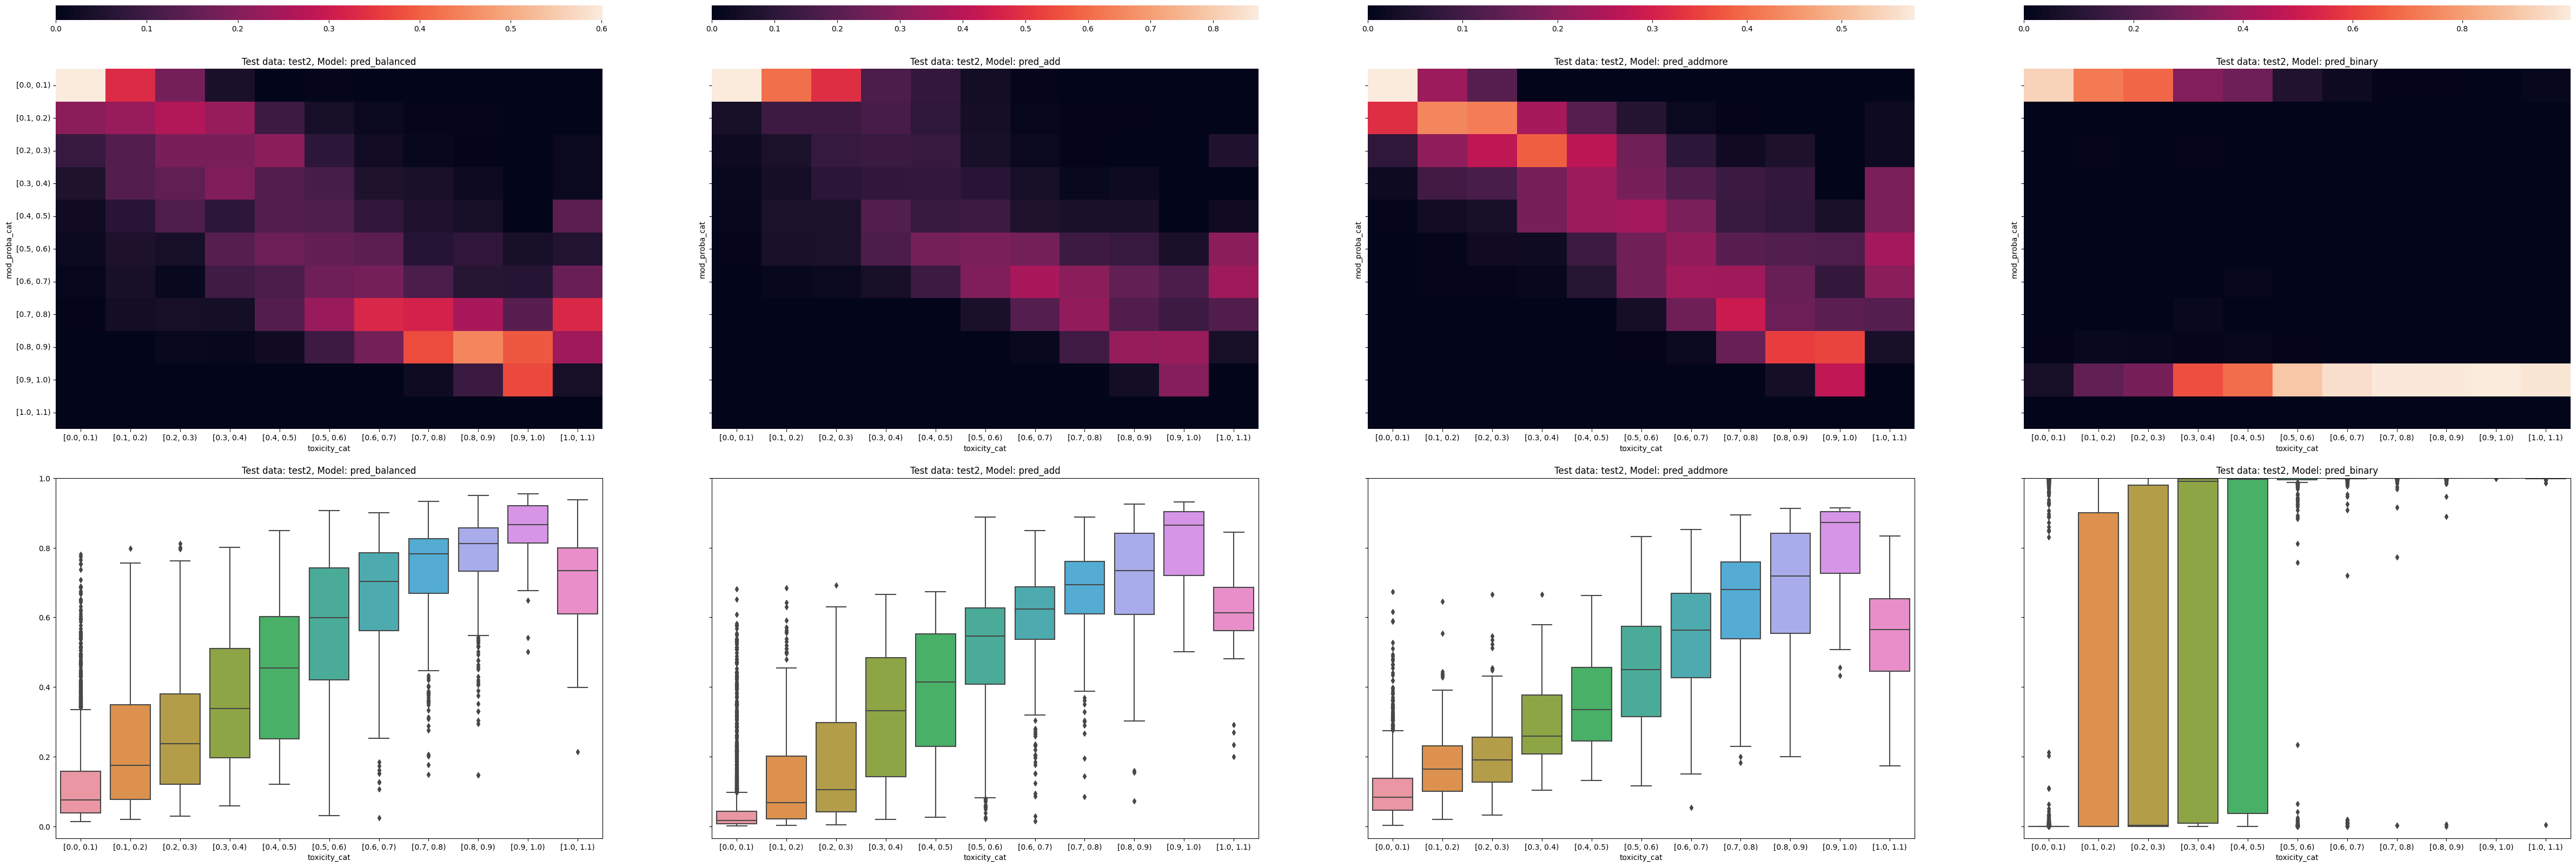

In [98]:
res = dict(test={}, test2={})
for dataset_name in ['test', 'test2']:
    fig, axes = plt.subplots(nrows=3, ncols=4, sharey='row', figsize=[60, 20], height_ratios=[0.02, 0.49, 0.49], squeeze=True)
    for i, model_name in enumerate(['balanced', 'add', 'addmore', 'binary']):
        cbar_option = False if i != 3 else True
        cbar_axis = None if i != 3 else axes[0, i]
        plot_heatmap(eval(dataset_name), dataset_name, f'pred_{model_name}', axes[1, i], True, axes[0, i])
        plot_boxplot(eval(dataset_name), dataset_name, f'pred_{model_name}', axes[2, i])


In [102]:
# load jsonl
train=pd.read_json("./data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/fine-grained/train.jsonl",lines=True)
train2=pd.read_json("./data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/fine-grained/train_mucoco+add.jsonl",lines=True)
train3=pd.read_json("./data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/fine-grained/train_mucoco+addmore.jsonl",lines=True)
train0_0=pd.read_json("./data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/train_0.jsonl",lines=True)
train0_1=pd.read_json("./data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/train_1.jsonl",lines=True)

# noticed that there are samples with label value NaN
train = train.loc[~train['toxicity'].isna()]
train2 = train2.loc[~train2['toxicity'].isna()]
train3 = train3.loc[~train3['toxicity'].isna()]

# add label for binary data
train0_0['toxicity']=0
train0_1['toxicity']=1
train0 = pd.concat([train0_0, train0_1], axis=0); del train0_0, train0_1

In [105]:
train_data_dict = {'balanced': train, 'add': train2, 'addmore': train3, 'binary': train0}

In [113]:
train['toxicity_cat']=pd.cut(train['toxicity'], np.arange(0, 1.11, 0.1), include_lowest=False, right=False)
train.groupby('toxicity_cat').size().reset_index().rename(columns={0: 'count'})

,toxicity_cat,count
0,"[0.0, 0.1)",4247
1,"[0.1, 0.2)",4247
2,"[0.2, 0.3)",2740
3,"[0.3, 0.4)",5754
4,"[0.4, 0.5)",4247
5,"[0.5, 0.6)",2798
6,"[0.6, 0.7)",3551
7,"[0.7, 0.8)",6392
8,"[0.8, 0.9)",4248
9,"[0.9, 1.0)",4247


In [126]:
def plot_train_dist(input_train_data, input_column_name, input_plot_axis):
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    copy_train_data = input_train_data[['toxicity']].copy()
    # bin toxicity columns values
    copy_train_data['toxicity_cat']=pd.cut(copy_train_data['toxicity'], np.arange(0, 1.11, 0.1), include_lowest=False, right=False)
    # barplot_data = copy_train_data.groupby('toxicity_cat').apply(lambda x: x.size/len(copy_train_data)).reset_index().rename(columns={0: 'count'})
    barplot_data = copy_train_data.groupby('toxicity_cat').apply(lambda x: x.size).reset_index().rename(columns={0: 'count'})
    
    sns.barplot(data = barplot_data, x = 'toxicity_cat', y = 'count', ax=input_plot_axis)
    input_plot_axis.set_title(f'Train data composition (count) for Model: {input_column_name}')
    input_plot_axis.set_ylabel('')

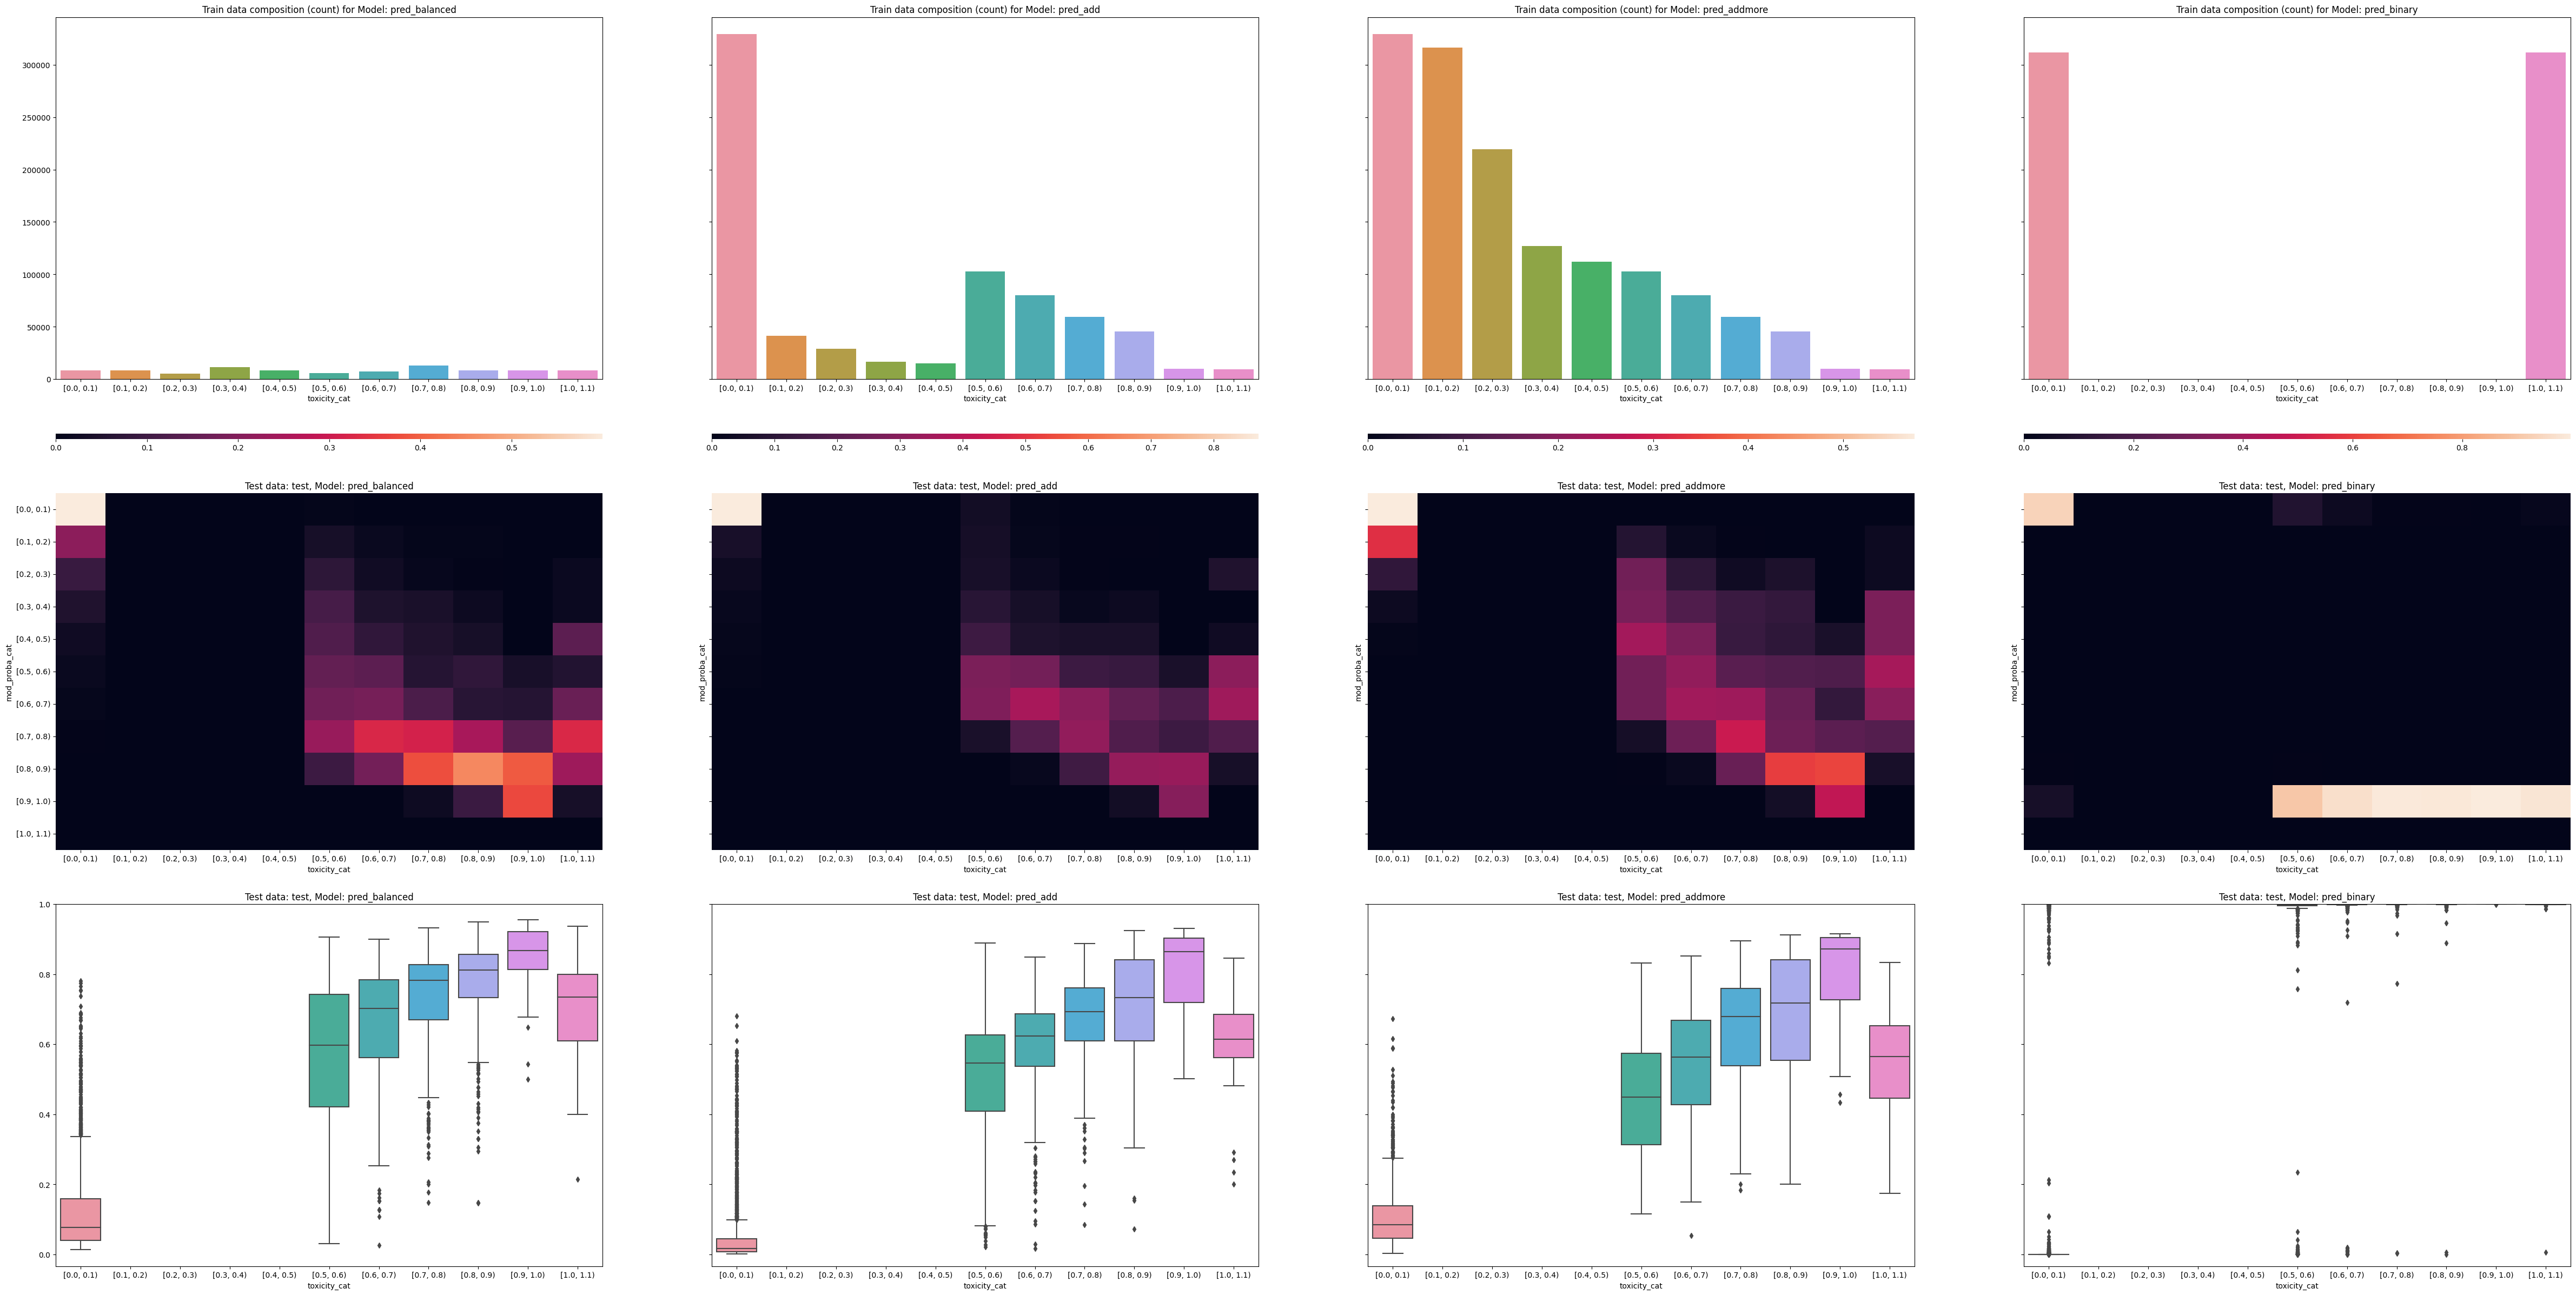

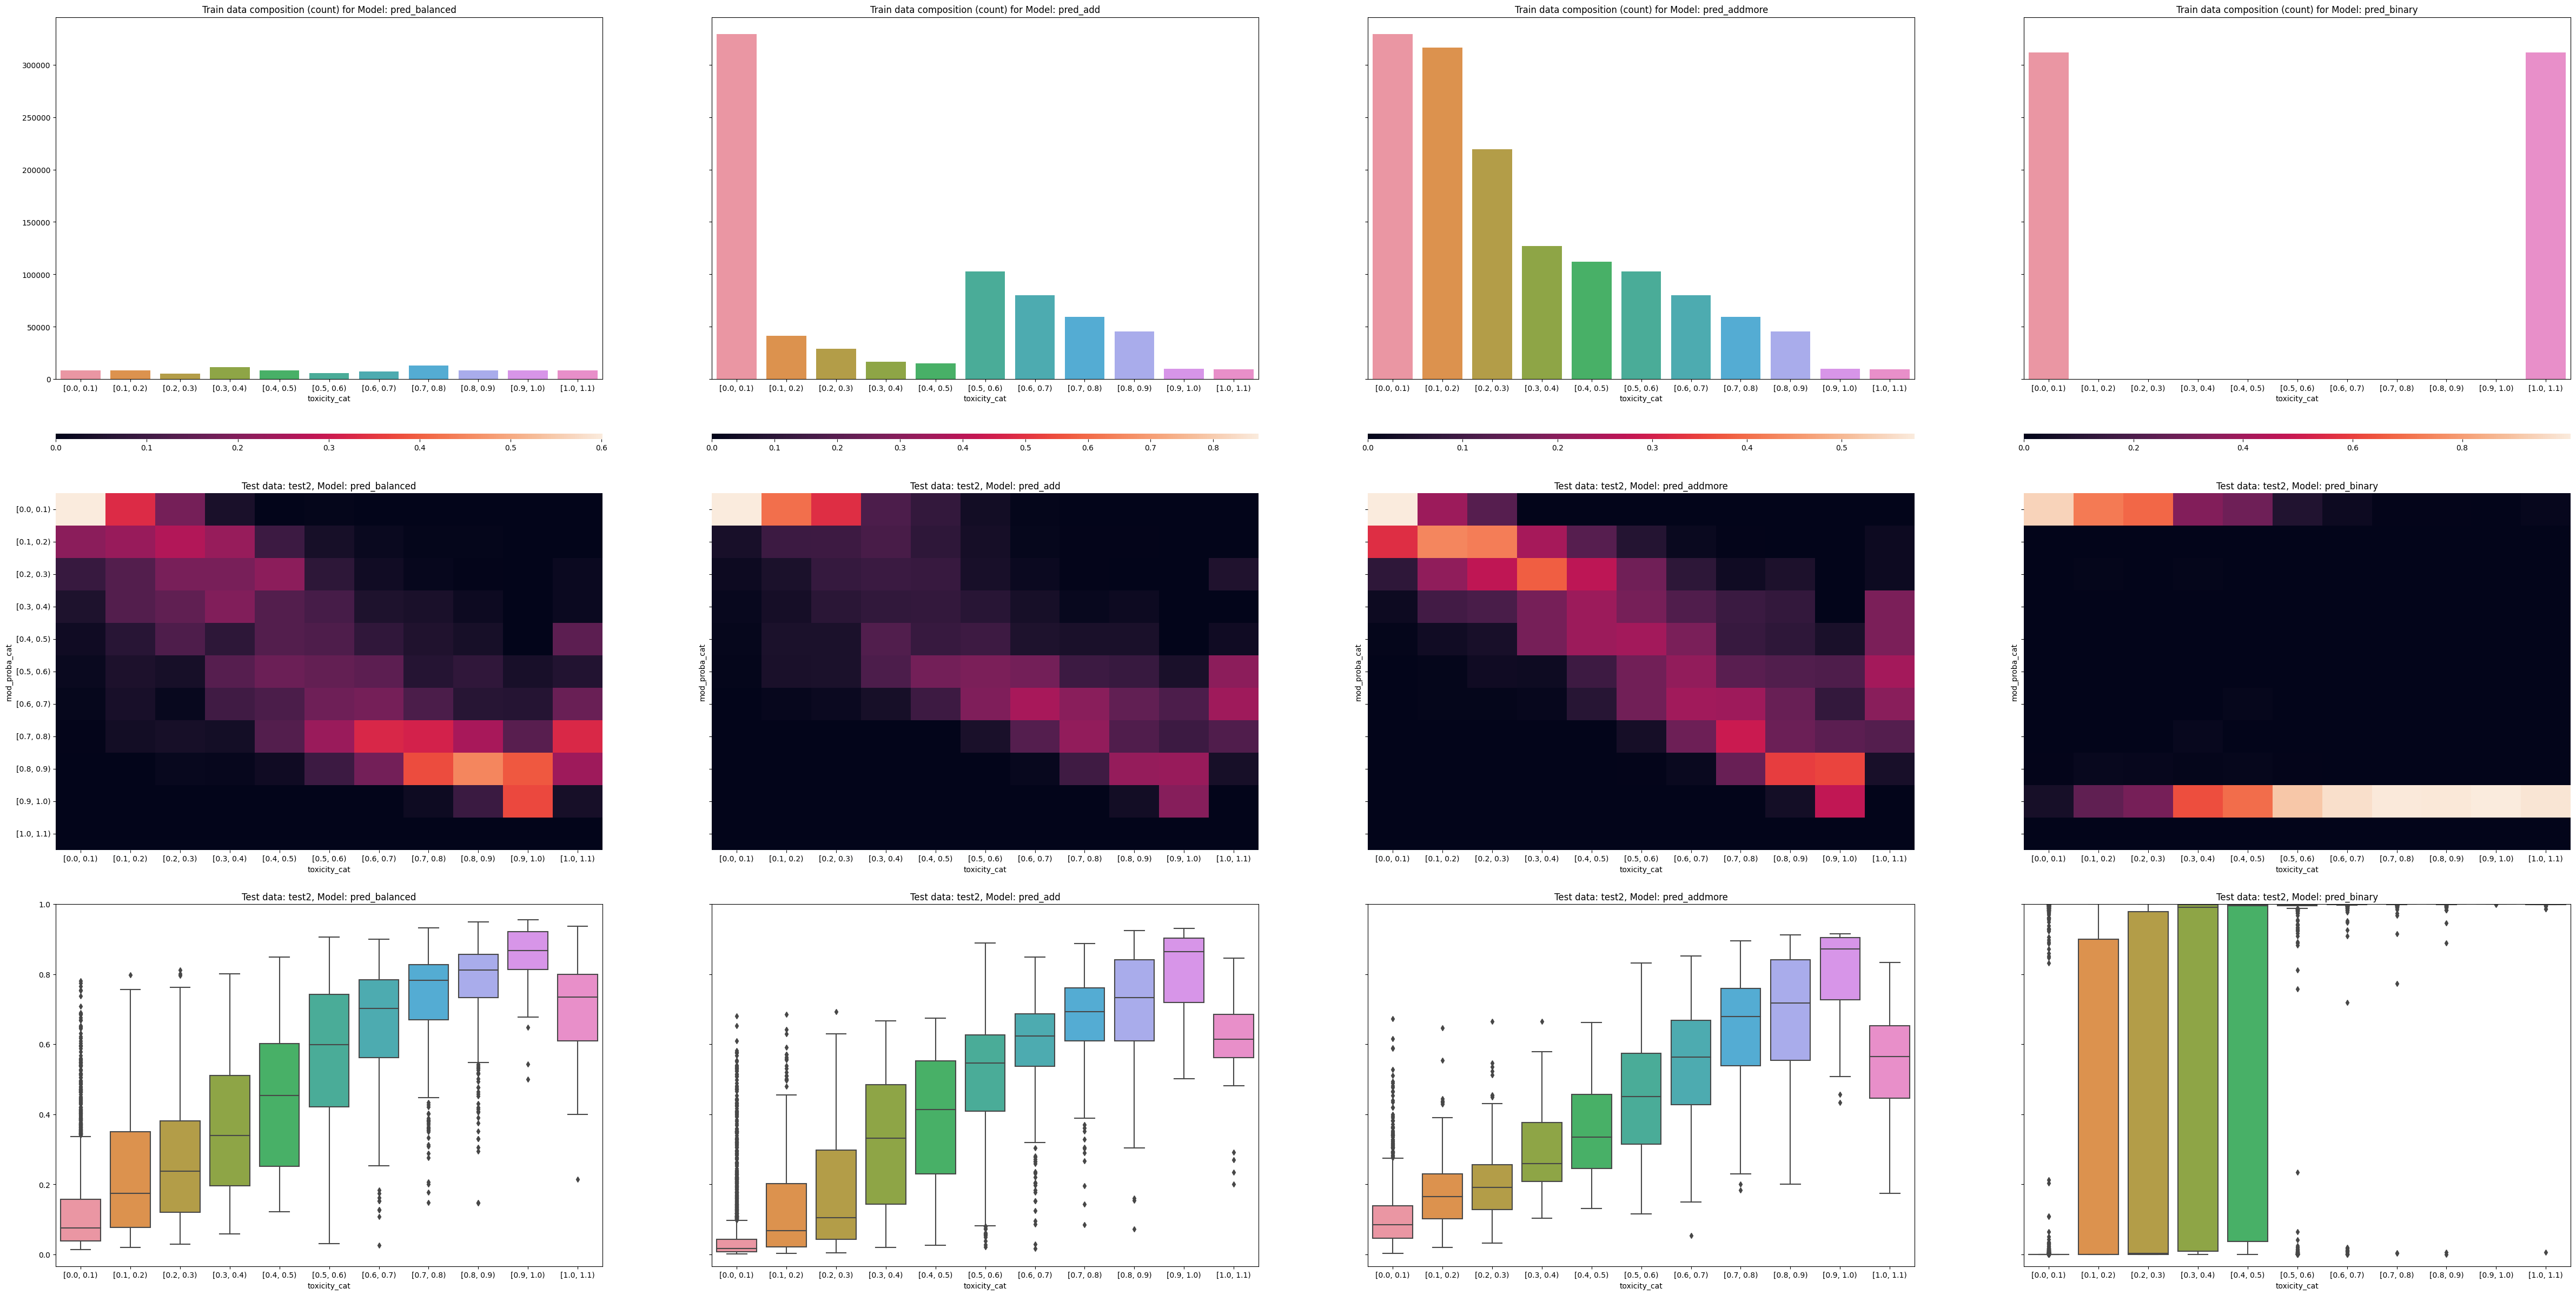

In [127]:
res = dict(test={}, test2={})
for dataset_name in ['test', 'test2']:
    fig, axes = plt.subplots(nrows=4, ncols=4, sharey='row', figsize=[60, 30], height_ratios=[0.33, 0.005, 0.325, 0.33], squeeze=True)
    for i, model_name in enumerate(['balanced', 'add', 'addmore', 'binary']):
        cbar_option = False if i != 3 else True
        cbar_axis = None if i != 3 else axes[0, i]
        plot_train_dist(train_data_dict[model_name], f'pred_{model_name}', axes[0, i])
        plot_heatmap(eval(dataset_name), dataset_name, f'pred_{model_name}', axes[2, i], True, axes[1, i])
        plot_boxplot(eval(dataset_name), dataset_name, f'pred_{model_name}', axes[3, i])

# Calculate accuracy

In [2]:
test = pd.read_csv('notebooks/results/test_preds.csv')
test2 = pd.read_csv('notebooks/results/test_mucoco+add_preds.csv')

In [3]:
test

,text,toxicity,pred_balanced,pred_add,pred_addmore,pred_binary
0,Average Canadian household debt is at 170% (de...,0.000000,0.051902,0.004412,0.030994,0.000163
1,And if they are concerned about the insurance ...,0.000000,0.035364,0.005099,0.037283,0.000157
2,You do realize ALL CAPS is a sure sign of psyc...,0.000000,0.291894,0.086599,0.183628,0.007955
3,The North Carolina newspaper should do a story...,0.000000,0.273441,0.066725,0.170421,0.000489
4,The difference is that he is not being paid by...,0.000000,0.420837,0.575274,0.454082,0.999464
...,...,...,...,...,...,...
3944,I don’t see it happening because of all the pr...,0.750000,0.878362,0.815559,0.859540,0.999729
3945,Every time a lib opens his mouth more garbage ...,0.600000,0.575654,0.564454,0.455786,0.999657
3946,the dealers don't have a hard time making mone...,0.738462,0.827819,0.814260,0.818498,0.999745
3947,My opinion is Trump keeps opening his mouth an...,0.600000,0.390768,0.363219,0.302119,0.989783


In [13]:
res_dict={}

for model_name in ['balanced', 'add', 'addmore', 'binary']:
    res_dict[model_name]= {}
    for cutoff in [0.5, 0.6, 0.7]:
        c_label = test2['toxicity'].apply(lambda x: 1 if x >= cutoff else 0)
        c_pred = test2[f'pred_{model_name}'].apply(lambda x: 1 if x >= cutoff else 0)
        res_dict[f'{model_name}'][f'{cutoff}'] = round(accuracy_score(c_label, c_pred), 3)

In [14]:
pd.DataFrame(res_dict)

,balanced,add,addmore,binary
0.5,0.879,0.885,0.823,0.902
0.6,0.846,0.855,0.843,0.782
0.7,0.843,0.879,0.882,0.679


In [15]:
res_dict={}

for model_name in ['balanced', 'add', 'addmore', 'binary']:
    res_dict[model_name]= {}
    for cutoff in [0.5, 0.6, 0.7]:
        c_label = test['toxicity'].apply(lambda x: 1 if x >= cutoff else 0)
        c_pred = test[f'pred_{model_name}'].apply(lambda x: 1 if x >= cutoff else 0)
        res_dict[f'{model_name}'][f'{cutoff}'] = round(accuracy_score(c_label, c_pred), 3)

In [16]:
pd.DataFrame(res_dict)

,balanced,add,addmore,binary
0.5,0.889,0.891,0.805,0.947
0.6,0.840,0.841,0.822,0.810
0.7,0.829,0.861,0.866,0.693
